<h3 align="center">Codebasics ML Course: ROC AUC Curve: Cost Benefit Analysis</h3>

We will generate synthetic dataset using make_classification method

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

X, y = make_classification(
    n_features=10, 
    n_samples=1000, 
    n_informative=4,
    n_redundant=6,
    n_repeated=0,
    n_classes=2, 
    random_state=42
)

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

### Train a Logistic Regression Model

In [2]:
from sklearn.metrics import classification_report

model = LogisticRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.66      0.69      0.67       122
           1       0.69      0.66      0.68       128

    accuracy                           0.68       250
   macro avg       0.68      0.68      0.68       250
weighted avg       0.68      0.68      0.68       250



Let's assume above is the classification model for pneumonia detection. In this case, a recall of 0.66 for positive class is pretty bad because out of 100 psenumonia patients you are detecting the disease only in 66 and to remaining 34 patients you are saying you don't have a disease. We would like to increase this number even though it comes at the cost of increased false positives (i.e. telling a person that you have pneumonia, when in reality they don't).

Reduce the probability threshold to 0.4 (from a default of 0.5) to capture more cases of pneumonia

#### Change the thresold to see how precision, recall changes

In [21]:
probabilities = model.predict_proba(X_test)[:,1]
y_pred = (probabilities > 0.4).astype(int)
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.89      0.90      0.90       122
           1       0.91      0.90      0.90       128

    accuracy                           0.90       250
   macro avg       0.90      0.90      0.90       250
weighted avg       0.90      0.90      0.90       250



As you can see here for class 1, the recall increased to 82%. Which is good but now by business manager is saying they need 90% recall. We will find probability thresold associated with 90% recall using ROC curve.

### Calculate FPR, TPR

In [26]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test, probabilities)


fpr,tpr,thresholds

(array([0.        , 0.        , 0.        , 0.00819672, 0.00819672,
        0.00819672, 0.00819672, 0.01639344, 0.01639344, 0.02459016,
        0.02459016, 0.04098361, 0.04098361, 0.04918033, 0.04918033,
        0.05737705, 0.05737705, 0.06557377, 0.06557377, 0.09016393,
        0.09016393, 0.09836066, 0.09836066, 0.10655738, 0.10655738,
        0.1147541 , 0.1147541 , 0.12295082, 0.12295082, 0.14754098,
        0.14754098, 0.28688525, 0.28688525, 0.30327869, 0.32786885,
        0.45901639, 0.45901639, 0.47540984, 0.47540984, 0.67213115,
        0.67213115, 0.69672131, 0.69672131, 0.82786885, 0.82786885,
        0.86885246, 0.86885246, 1.        ]),
 array([0.       , 0.0078125, 0.09375  , 0.09375  , 0.203125 , 0.21875  ,
        0.3984375, 0.3984375, 0.5859375, 0.5859375, 0.84375  , 0.84375  ,
        0.859375 , 0.859375 , 0.875    , 0.875    , 0.8828125, 0.8828125,
        0.890625 , 0.890625 , 0.8984375, 0.8984375, 0.90625  , 0.90625  ,
        0.9140625, 0.9140625, 0.9296875, 0.929

In [5]:
desired_recall = 0.9

closest_index = np.argmin(abs(tpr-desired_recall))
tpr[closest_index], thresholds[closest_index], fpr[closest_index]

(np.float64(0.90625),
 np.float64(0.26349585272229664),
 np.float64(0.7049180327868853))

What this is saying is you need to configure your probability threshold to be 0.26 for a desired_recall value. Also you will have 0.7 false positive rate which is pretty high. Do not worry because later we will try a better model (XGBoost)

### Calculate AUC

In [6]:
from sklearn.metrics import auc

area = auc(fpr, tpr)
area

np.float64(0.764856557377049)

### Plot ROC Curve

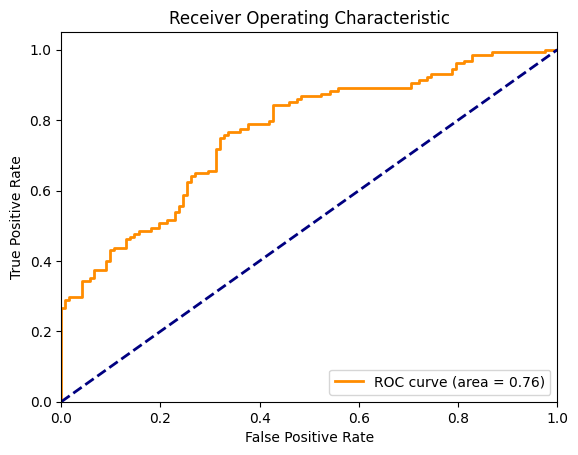

In [7]:
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % area)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

### Now Train XGBoost Model

In [8]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report

model = XGBClassifier()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.89      0.93      0.91       122
           1       0.93      0.89      0.91       128

    accuracy                           0.91       250
   macro avg       0.91      0.91      0.91       250
weighted avg       0.91      0.91      0.91       250



Out of the box, it gives us 89% recall which is pretty good but now my business manager becomes greedy and asks for 92% recall.

In [9]:
probabilities_xgb = model.predict_proba(X_test)[:,1]
fpr_xgb, tpr_xgb, thresholds_xgb = roc_curve(y_test, probabilities_xgb)

fpr_xgb[:5], tpr_xgb[:5], thresholds_xgb[:5]

(array([0.        , 0.        , 0.        , 0.00819672, 0.00819672]),
 array([0.       , 0.0078125, 0.09375  , 0.09375  , 0.203125 ]),
 array([       inf, 0.99996376, 0.99989676, 0.999892  , 0.9997204 ],
       dtype=float32))

In [10]:
area2 = auc(fpr_xgb, tpr_xgb)
area2

np.float64(0.946016905737705)

### Plot ROC Curve for Logistic Regression and XGBoost Side by Side

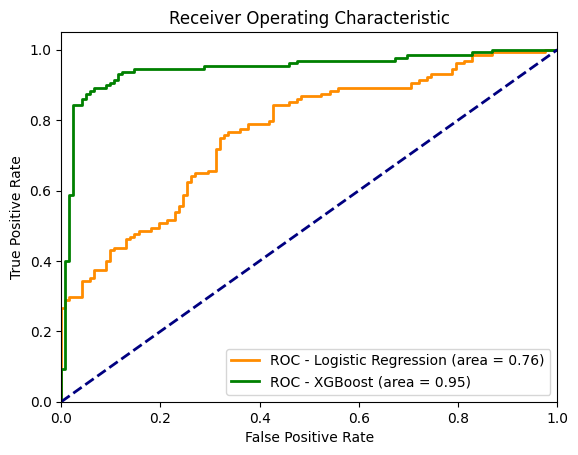

In [11]:
plt.figure()

plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC - Logistic Regression (area = %0.2f)' % area)
plt.plot(fpr_xgb, tpr_xgb, color='green', lw=2, label='ROC - XGBoost (area = %0.2f)' % area2)

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In the chart above, you can see XGBoost is much better model compared to logistic regression

In [12]:
desired_recall = 0.92

closest_index = np.argmin(abs(tpr_xgb-desired_recall))
tpr_xgb[closest_index], thresholds_xgb[closest_index], fpr_xgb[closest_index]

(np.float64(0.9140625),
 np.float32(0.30599597),
 np.float64(0.10655737704918032))

Threshold associated with 92% recall is 0.3, we will incorporate this in our inference code and deploy the model. Note that with this we will get a false positive rate of around 10% (0.106)